# Softmax

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

from d2l.tensorflow import config

config.setup()

In [2]:
ds = tfds.load('fashion_mnist', shuffle_files=True)

batch_size = 256

In [3]:
def transform(example):
    return example['image'] / 255, example['label']

In [4]:
fashion_mnist_train = ds['train'].shuffle(1024).batch(batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
).map(transform)

fashion_mnist_test = ds['test'].shuffle(1024).batch(batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
).map(transform)

## Initialize params

In [5]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(mean=0, stddev=0.1, shape=(num_inputs, num_outputs)))
b = tf.Variable(tf.zeros(num_outputs))

## The softmax

In [6]:
def softmax(X):
    X_exp = tf.math.exp(X)
    partition = tf.reduce_sum(X_exp, axis=1, keepdims=True)
    return X_exp / partition

## The model

In [7]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, num_inputs)), W) + b)

## The loss function

In [8]:
def cross_entropy(y_hat, y):
    return -tf.math.log( 
        tf.gather_nd(y_hat, tf.reshape(y, (-1, 1)), batch_dims=1) 
    )

## Classification accuracy

In [9]:
def accuracy(y_hat, y):
    hits = tf.math.equal( tf.math.argmax(y_hat, axis=1) , y)
    return tf.math.reduce_sum(
        tf.cast( hits , dtype=tf.int32)
    )

In [10]:
class Accumulator:
    """Sum a list of numbers over time."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
def evaluate_accuracy(model, data_iter):
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(model(X), y), y.shape[0])
    return metric[0] / metric[1]

## Training

In [12]:
def train_epoch(net, data_iter, loss):
    metric = Accumulator(3)  # train_loss_sum, train_acc_sum, num_examples

    for X, y in data_iter:
        with tf.GradientTape() as t:
            y_hat = net(X)
            l = loss(y_hat, y)
        dW, db = t.gradient(l, [W, b])
        W.assign_sub((lr * dW) / batch_size)
        b.assign_sub((lr * db) / batch_size)
        metric.add(tf.reduce_sum(l), accuracy(y_hat, y), y.shape[0])
    
     # Return training loss and training accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

In [13]:
import matplotlib.pyplot as plt
from IPython import display

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(15, 10)):
        """Incrementally plot multiple lines."""
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: self.set_axes(
            xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
    
    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib."""
        self.axes[0].set_xlabel(xlabel)
        self.axes[0].set_ylabel(ylabel)
        self.axes[0].set_xscale(xscale)
        self.axes[0].set_yscale(yscale)
        self.axes[0].set_xlim(xlim)
        self.axes[0].set_ylim(ylim)
        if legend:
            self.axes[0].legend(legend)
        self.axes[0].grid()

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
def train(net, train_iter, test_iter, loss, num_epochs):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

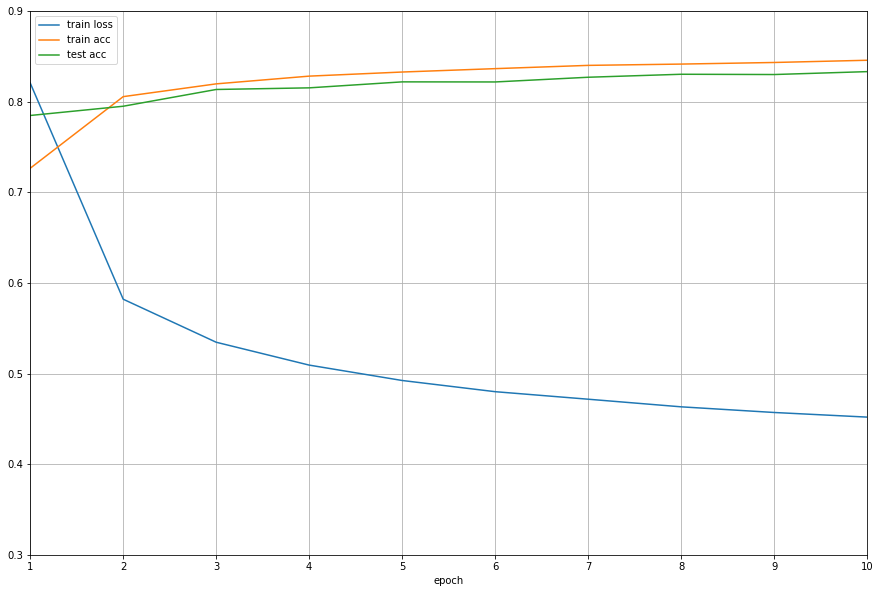

In [15]:
num_epochs, lr = 10, 0.1

train(net, fashion_mnist_train, fashion_mnist_test, cross_entropy, num_epochs)

## Prediction 

In [16]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):        
        if 'asnumpy' in dir(img): img = img.asnumpy() 
        if 'numpy' in dir(img): img = img.numpy()
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [17]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

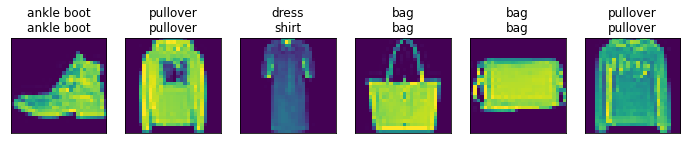

In [18]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(tf.math.argmax(net(X), axis=1))
    titles = [true+'\n' + pred for true, pred in zip(trues, preds)]
    show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict(net, fashion_mnist_test)